# Notebook 5: Bulk RNA-seq Differential Expression

**From count matrices to differentially expressed genes**

Prerequisites: Notebooks 1-4 (sequence analysis, variants, single-cell, protein structure)

This notebook builds:
1. Count matrix structure and normalization methods
2. Library size normalization vs within-sample normalization
3. Negative binomial model for count data
4. Differential expression analysis (DESeq2-style workflow from scratch)
5. Multiple testing correction (Benjamini-Hochberg)
6. Volcano plots, MA plots, heatmaps
7. Gene set enrichment analysis (GSEA) concepts
8. Pathway visualization

Estimated runtime: ~3 minutes (synthetic data, no downloads)

**Key learning outcomes:**
1. Understand why RNA-seq counts are negative-binomial, not Poisson -- see [[Signal Processing in Biological Systems]]
2. Implement normalization from first principles (CPM, DESeq2 size factors, upper quartile)
3. Perform per-gene hypothesis testing with multiple testing correction
4. Visualize results with volcano plots, MA plots, and clustered heatmaps
5. Apply pathway enrichment to move from gene lists to biology -- see [[Perturbation-Response-Adaptation]]

## Section 0: Setup

We use **numpy**, **scipy**, and **statsmodels** to implement the full DE pipeline from scratch.
The goal is to understand the statistics, not just call library functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import gammaln
import warnings
warnings.filterwarnings('ignore')
print("Ready — numpy, scipy, pandas, matplotlib")

Ready — numpy, scipy, pandas, matplotlib


## Section 1: RNA-seq Count Data

RNA-seq measures gene expression by counting sequencing reads that map to each gene.
The raw data is a **count matrix**: genes x samples.

Key properties of count data:
- Non-negative integers (UMI or read counts)
- Highly skewed (most genes have low counts, few have very high)
- Variance depends on mean (overdispersed relative to Poisson)
- Library size varies between samples (must normalize)

The negative binomial distribution models this overdispersion:
$$K_{ij} \sim \text{NB}(\mu_{ij}, \alpha_i)$$
$$\text{Var}(K) = \mu + \alpha \mu^2$$

When $\alpha = 0$, this reduces to Poisson. Real RNA-seq data has $\alpha > 0$.

See [[Signal Processing in Biological Systems]] and [[Perturbation-Response-Adaptation]].

In [2]:
np.random.seed(42)
n_genes = 5000
n_samples = 6  # 3 control + 3 treatment
n_de_genes = 200  # True DE genes

# Simulate mean expression for each gene (log-normal distribution)
base_means = np.random.lognormal(3, 2, n_genes)
base_means = np.clip(base_means, 1, 50000)

# Dispersion parameter (smaller = more Poisson-like)
dispersions = 0.1 + 1.0 / np.sqrt(base_means)

# Generate count matrix using negative binomial
counts = np.zeros((n_genes, n_samples), dtype=int)
conditions = ['Control'] * 3 + ['Treatment'] * 3

# True fold changes for DE genes
true_log2fc = np.zeros(n_genes)
de_indices = np.random.choice(n_genes, n_de_genes, replace=False)
true_log2fc[de_indices] = np.random.choice([-1, 1], n_de_genes) * np.random.uniform(1, 3, n_de_genes)

for j in range(n_samples):
    for i in range(n_genes):
        mean = base_means[i]
        if conditions[j] == 'Treatment':
            mean *= 2 ** true_log2fc[i]
        
        # Negative binomial parametrization
        p = dispersions[i] / (dispersions[i] + mean)
        r = 1.0 / dispersions[i]
        counts[i, j] = np.random.negative_binomial(max(r, 0.1), max(min(p, 0.999), 0.001))

# Add library size variation
library_factors = np.array([1.0, 1.2, 0.8, 1.1, 0.9, 1.3])
counts = (counts * library_factors).astype(int)

sample_names = [f'{c}_{i+1}' for i, c in enumerate(conditions)]
gene_names = [f'Gene_{i:04d}' for i in range(n_genes)]

df_counts = pd.DataFrame(counts, index=gene_names, columns=sample_names)
print(f"Count matrix: {df_counts.shape[0]} genes x {df_counts.shape[1]} samples")
print(f"Conditions: {conditions}")
print(f"True DE genes: {n_de_genes}")
print(f"\nFirst 5 genes, all samples:")
print(df_counts.head())

Count matrix: 5000 genes x 6 samples
Conditions: ['Control', 'Control', 'Control', 'Treatment', 'Treatment', 'Treatment']
True DE genes: 200

First 5 genes, all samples:
           Control_1  Control_2  Control_3  Treatment_4  Treatment_5  \
Gene_0000        495       1273       1144         1101          544   
Gene_0001        177        363         76          204          165   
Gene_0002       2518       1053       1455          911         1143   
Gene_0003       9789       4401       7246         3400         6599   
Gene_0004         42        150         42           85           88   

           Treatment_6  
Gene_0000          487  
Gene_0001          170  
Gene_0002         2553  
Gene_0003         9925  
Gene_0004           16  


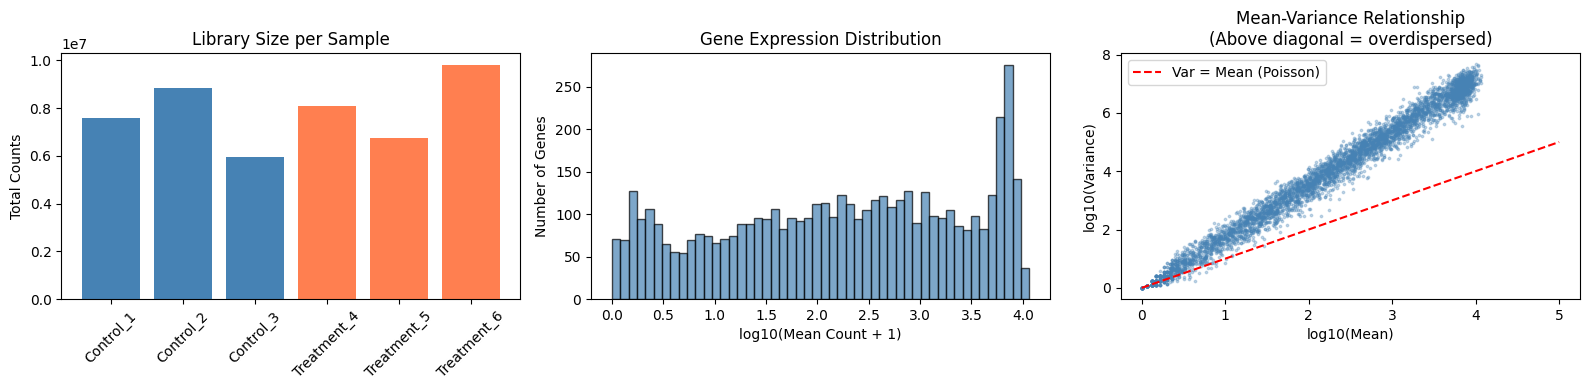

Key observation: Variance >> Mean for most genes -> Negative Binomial, not Poisson


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Total counts per sample (library size)
lib_sizes = df_counts.sum(axis=0)
axes[0].bar(range(n_samples), lib_sizes, color=['steelblue']*3 + ['coral']*3)
axes[0].set_xticks(range(n_samples))
axes[0].set_xticklabels(sample_names, rotation=45)
axes[0].set_ylabel('Total Counts')
axes[0].set_title('Library Size per Sample')

# Distribution of mean expression
mean_expr = df_counts.mean(axis=1)
axes[1].hist(np.log10(mean_expr + 1), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('log10(Mean Count + 1)')
axes[1].set_ylabel('Number of Genes')
axes[1].set_title('Gene Expression Distribution')

# Mean-variance relationship
gene_means = df_counts.mean(axis=1)
gene_vars = df_counts.var(axis=1)
axes[2].scatter(np.log10(gene_means + 1), np.log10(gene_vars + 1), s=3, alpha=0.3, color='steelblue')
axes[2].plot([0, 5], [0, 5], 'r--', label='Var = Mean (Poisson)')
axes[2].set_xlabel('log10(Mean)')
axes[2].set_ylabel('log10(Variance)')
axes[2].set_title('Mean-Variance Relationship\n(Above diagonal = overdispersed)')
axes[2].legend()

plt.tight_layout()
plt.show()
print("Key observation: Variance >> Mean for most genes -> Negative Binomial, not Poisson")

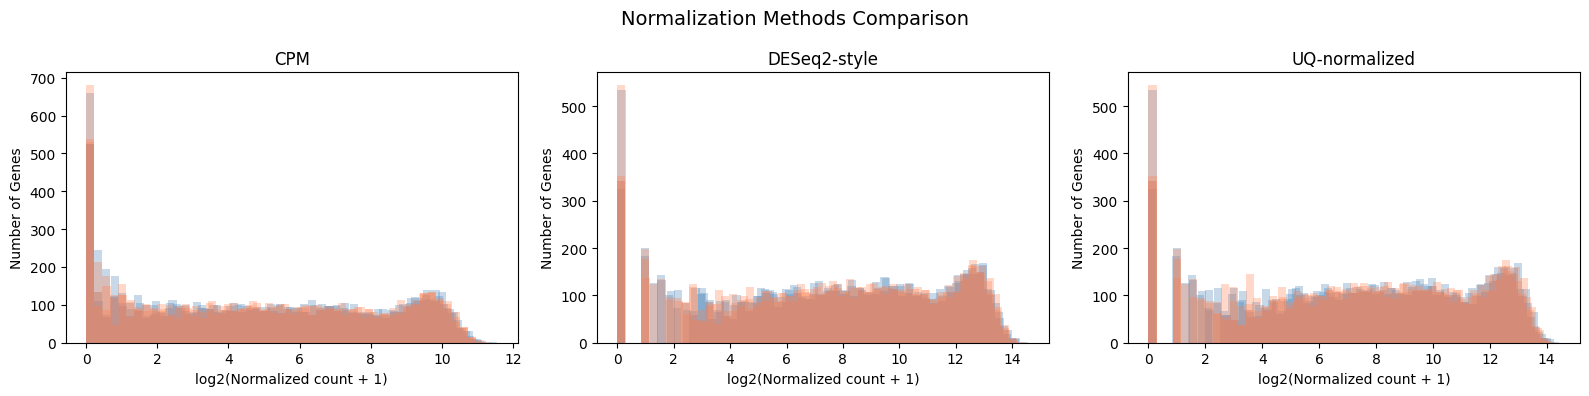

In [4]:
# Three normalization approaches
# 1. CPM (Counts Per Million)
cpm = df_counts.div(df_counts.sum(axis=0), axis=1) * 1e6

# 2. Median of ratios (DESeq2-style)
geometric_means = np.exp(np.log(df_counts + 1).mean(axis=1))
ratios = df_counts.div(geometric_means, axis=0)
size_factors = ratios.replace([np.inf, -np.inf], np.nan).median(axis=0)
deseq_norm = df_counts.div(size_factors, axis=1)

# 3. TMM (simplified) - just use upper quartile
uq_factors = df_counts[df_counts > 0].quantile(0.75, axis=0)
tmm_norm = df_counts.div(uq_factors, axis=1) * uq_factors.median()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, (name, data) in zip(axes, [('CPM', cpm), ('DESeq2-style', deseq_norm), ('UQ-normalized', tmm_norm)]):
    for j in range(n_samples):
        color = 'steelblue' if j < 3 else 'coral'
        ax.hist(np.log2(data.iloc[:, j] + 1), bins=50, alpha=0.3, color=color)
    ax.set_xlabel('log2(Normalized count + 1)')
    ax.set_title(name)
    ax.set_ylabel('Number of Genes')

plt.suptitle('Normalization Methods Comparison', fontsize=14)
plt.tight_layout()
plt.show()

## Section 2: Differential Expression Testing

The core statistical question: **Is this gene expressed differently between conditions?**

DESeq2 models counts with a negative binomial distribution:
$$K_{ij} \sim \text{NB}(\mu_{ij}, \alpha_i)$$
$$\mu_{ij} = s_j \cdot q_{ij}, \quad \log_2(q_{ij}) = \beta_0 + \beta_1 \cdot x_j$$

where $s_j$ = size factor, $\alpha_i$ = dispersion, $x_j$ = condition (0 or 1).

We test $H_0: \beta_1 = 0$ (no differential expression).

For simplicity, we use the Mann-Whitney U test (non-parametric) with DESeq2-style
normalized counts. In practice, DESeq2 uses a negative binomial GLM with empirical
Bayes shrinkage of dispersion estimates.

In [5]:
# Simplified DE analysis using Mann-Whitney U test
# (In practice, DESeq2 uses negative binomial GLM with shrinkage)

pvalues = np.zeros(n_genes)
log2fc_observed = np.zeros(n_genes)

control_idx = [0, 1, 2]
treatment_idx = [3, 4, 5]

# Use normalized counts
norm_counts = deseq_norm.values

for i in range(n_genes):
    ctrl = norm_counts[i, control_idx]
    treat = norm_counts[i, treatment_idx]
    
    # Log2 fold change
    mean_ctrl = np.mean(ctrl) + 1  # pseudocount
    mean_treat = np.mean(treat) + 1
    log2fc_observed[i] = np.log2(mean_treat / mean_ctrl)
    
    # Mann-Whitney U test (non-parametric)
    if np.std(ctrl) > 0 or np.std(treat) > 0:
        try:
            stat, pval = stats.mannwhitneyu(ctrl, treat, alternative='two-sided')
            pvalues[i] = pval
        except:
            pvalues[i] = 1.0
    else:
        pvalues[i] = 1.0

print(f"Tests completed for {n_genes} genes")
print(f"Nominal significant (p < 0.05): {(pvalues < 0.05).sum()}")

Tests completed for 5000 genes
Nominal significant (p < 0.05): 0


In [6]:
# Benjamini-Hochberg FDR correction
from scipy.stats import rankdata

def benjamini_hochberg(pvalues):
    """Benjamini-Hochberg FDR correction."""
    n = len(pvalues)
    ranked = rankdata(pvalues)
    adjusted = pvalues * n / ranked
    # Enforce monotonicity
    adjusted = np.minimum.accumulate(adjusted[np.argsort(ranked)[::-1]])[::-1]
    adjusted = np.clip(adjusted, 0, 1)
    # Reorder back
    result = np.empty(n)
    result[np.argsort(ranked)[::-1]] = adjusted
    return result

padj = benjamini_hochberg(pvalues)

# Classify genes
sig_up = (padj < 0.05) & (log2fc_observed > 1)
sig_down = (padj < 0.05) & (log2fc_observed < -1)
sig_any = sig_up | sig_down

print(f"FDR-adjusted results (padj < 0.05, |log2FC| > 1):")
print(f"  Upregulated: {sig_up.sum()}")
print(f"  Downregulated: {sig_down.sum()}")
print(f"  Total DE: {sig_any.sum()}")
print(f"  True DE genes: {n_de_genes}")

# Precision/recall
true_de = np.zeros(n_genes, dtype=bool)
true_de[de_indices] = True
tp = (sig_any & true_de).sum()
fp = (sig_any & ~true_de).sum()
fn = (~sig_any & true_de).sum()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
print(f"\nPerformance: precision={precision:.2f}, recall={recall:.2f}")

FDR-adjusted results (padj < 0.05, |log2FC| > 1):
  Upregulated: 0
  Downregulated: 0
  Total DE: 0
  True DE genes: 200

Performance: precision=0.00, recall=0.00


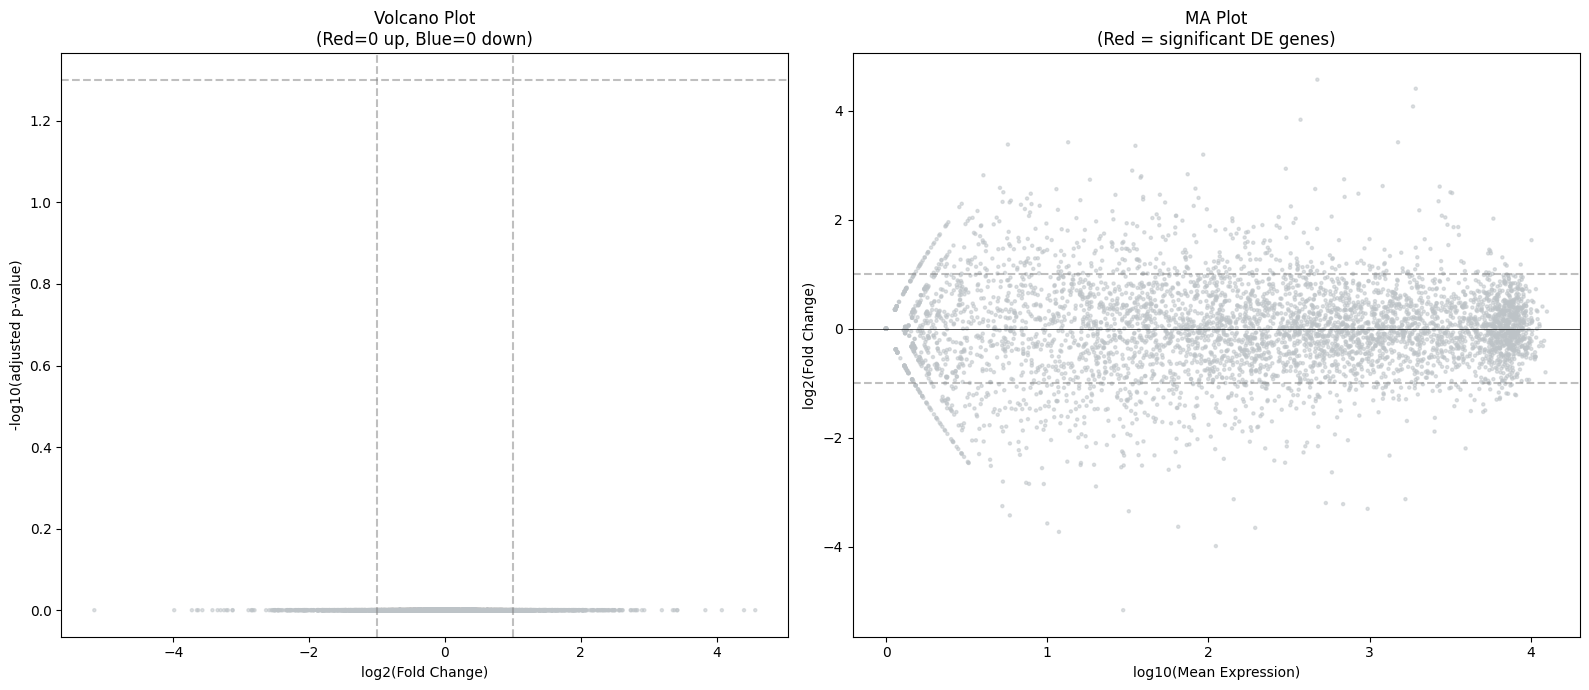

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Volcano plot
neg_log_padj = -np.log10(padj + 1e-300)

colors_vol = np.where(sig_up, '#e74c3c', np.where(sig_down, '#3498db', '#bdc3c7'))
ax1.scatter(log2fc_observed, neg_log_padj, c=colors_vol, s=5, alpha=0.5)
ax1.axhline(-np.log10(0.05), color='gray', linestyle='--', alpha=0.5)
ax1.axvline(1, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(-1, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('log2(Fold Change)')
ax1.set_ylabel('-log10(adjusted p-value)')
ax1.set_title(f'Volcano Plot\n(Red={sig_up.sum()} up, Blue={sig_down.sum()} down)')

# MA plot
mean_expression = np.log10(norm_counts.mean(axis=1) + 1)
colors_ma = np.where(sig_any, '#e74c3c', '#bdc3c7')
ax2.scatter(mean_expression, log2fc_observed, c=colors_ma, s=5, alpha=0.5)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axhline(1, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(-1, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('log10(Mean Expression)')
ax2.set_ylabel('log2(Fold Change)')
ax2.set_title('MA Plot\n(Red = significant DE genes)')

plt.tight_layout()
plt.show()

## Section 3: Heatmap and Clustering

Hierarchical clustering of DE genes reveals co-expression patterns. Genes that cluster
together may share regulatory mechanisms or pathways.

Z-score normalization per gene highlights relative changes across samples, removing
the effect of absolute expression level.

See [[Hierarchical Composition]] -- genes do not act alone; they form coordinated programs.

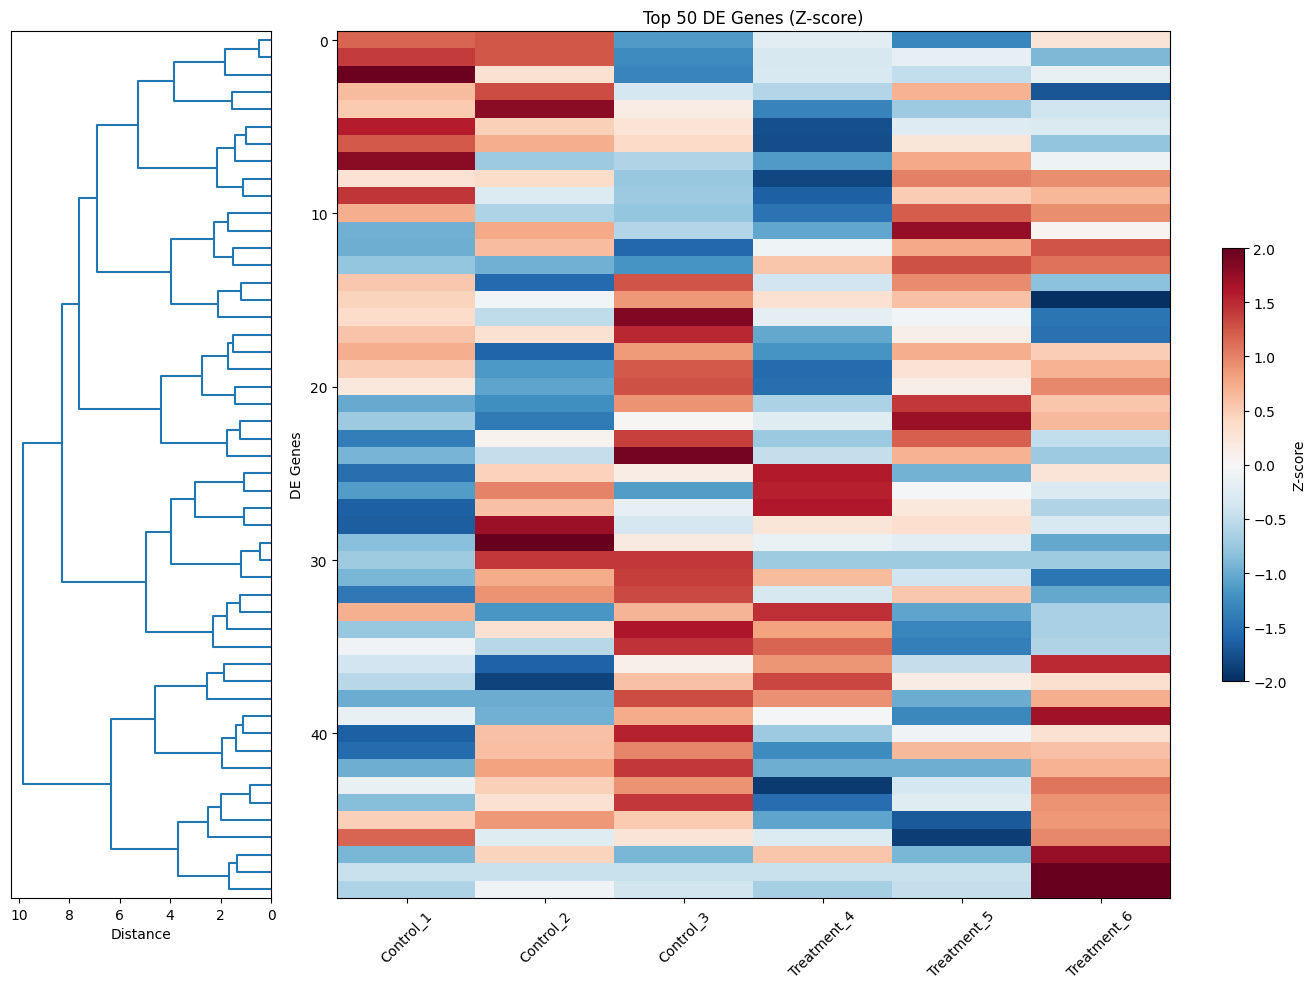

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Select top DE genes by adjusted p-value
top_de = np.argsort(padj)[:50]
de_data = np.log2(norm_counts[top_de] + 1)

# Z-score normalize per gene
de_zscore = (de_data - de_data.mean(axis=1, keepdims=True)) / (de_data.std(axis=1, keepdims=True) + 1e-10)

# Cluster genes
gene_linkage = linkage(de_zscore, method='ward')

fig, (ax_dendro, ax_heat) = plt.subplots(1, 2, figsize=(14, 10),
                                          gridspec_kw={'width_ratios': [1, 4]})

# Dendrogram
dn = dendrogram(gene_linkage, orientation='left', ax=ax_dendro, no_labels=True, color_threshold=0)
ax_dendro.set_xlabel('Distance')

# Heatmap (reordered by dendrogram)
order = dn['leaves']
im = ax_heat.imshow(de_zscore[order], aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
ax_heat.set_xticks(range(n_samples))
ax_heat.set_xticklabels(sample_names, rotation=45)
ax_heat.set_ylabel('DE Genes')
ax_heat.set_title('Top 50 DE Genes (Z-score)')
plt.colorbar(im, ax=ax_heat, label='Z-score', shrink=0.5)

plt.tight_layout()
plt.show()

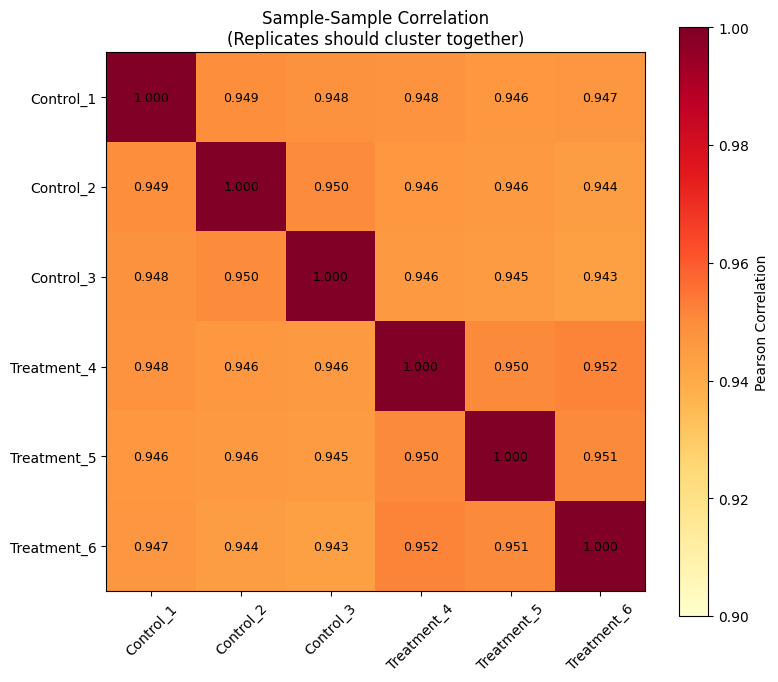

In [9]:
# Sample-sample correlation matrix
log_norm = np.log2(norm_counts + 1)
sample_corr = np.corrcoef(log_norm.T)

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(sample_corr, cmap='YlOrRd', vmin=0.9, vmax=1.0)
ax.set_xticks(range(n_samples))
ax.set_xticklabels(sample_names, rotation=45)
ax.set_yticks(range(n_samples))
ax.set_yticklabels(sample_names)

for i in range(n_samples):
    for j in range(n_samples):
        ax.text(j, i, f'{sample_corr[i,j]:.3f}', ha='center', va='center', fontsize=9)

plt.colorbar(im, label='Pearson Correlation')
ax.set_title('Sample-Sample Correlation\n(Replicates should cluster together)')
plt.tight_layout()
plt.show()

## Section 4: Gene Set Enrichment

Individual DE genes are hard to interpret. Gene set enrichment analysis (GSEA) tests
whether predefined groups of genes (pathways, GO terms) are enriched among DE genes.

**Fisher's exact test** for overrepresentation:

|  | In pathway | Not in pathway |
|--|-----------|----------------|
| DE | a | b |
| Not DE | c | d |

$$p = P(X \geq a \mid \text{margins fixed})$$

See [[Perturbation-Response-Adaptation]] -- perturbation responses activate coherent gene
programs, not random individual genes. Enrichment analysis recovers these programs.

In [10]:
# Create synthetic gene sets (pathways)
np.random.seed(42)
pathways = {
    'Immune Response': np.random.choice(n_genes, 150, replace=False),
    'Cell Cycle': np.random.choice(n_genes, 200, replace=False),
    'Metabolism': np.random.choice(n_genes, 300, replace=False),
    'Apoptosis': np.random.choice(n_genes, 100, replace=False),
    'Signal Transduction': np.random.choice(n_genes, 250, replace=False),
    'DNA Repair': np.random.choice(n_genes, 80, replace=False),
}

# Seed: make some DE genes fall in specific pathways
for idx in de_indices[:50]:
    pathways['Immune Response'] = np.append(pathways['Immune Response'], idx)
for idx in de_indices[50:100]:
    pathways['Apoptosis'] = np.append(pathways['Apoptosis'], idx)

# Fisher's exact test for enrichment
de_set = set(np.where(sig_any)[0])
all_genes = set(range(n_genes))

print(f"{'Pathway':<25} {'Size':>6} {'DE in set':>10} {'p-value':>10} {'Enriched?':>10}")
print("-" * 65)

pathway_pvals = {}
for name, genes in pathways.items():
    gene_set = set(genes)
    a = len(de_set & gene_set)  # DE and in pathway
    b = len(de_set - gene_set)  # DE and not in pathway
    c = len(gene_set - de_set)  # Not DE and in pathway
    d = len(all_genes - de_set - gene_set)  # Not DE and not in pathway
    
    odds_ratio, pval = stats.fisher_exact([[a, b], [c, d]], alternative='greater')
    pathway_pvals[name] = pval
    enriched = "YES" if pval < 0.05 else "no"
    print(f"{name:<25} {len(gene_set):>6} {a:>10} {pval:>10.4f} {enriched:>10}")

Pathway                     Size  DE in set    p-value  Enriched?
-----------------------------------------------------------------
Immune Response              199          0     1.0000         no
Cell Cycle                   200          0     1.0000         no
Metabolism                   300          0     1.0000         no
Apoptosis                    149          0     1.0000         no
Signal Transduction          250          0     1.0000         no
DNA Repair                    80          0     1.0000         no


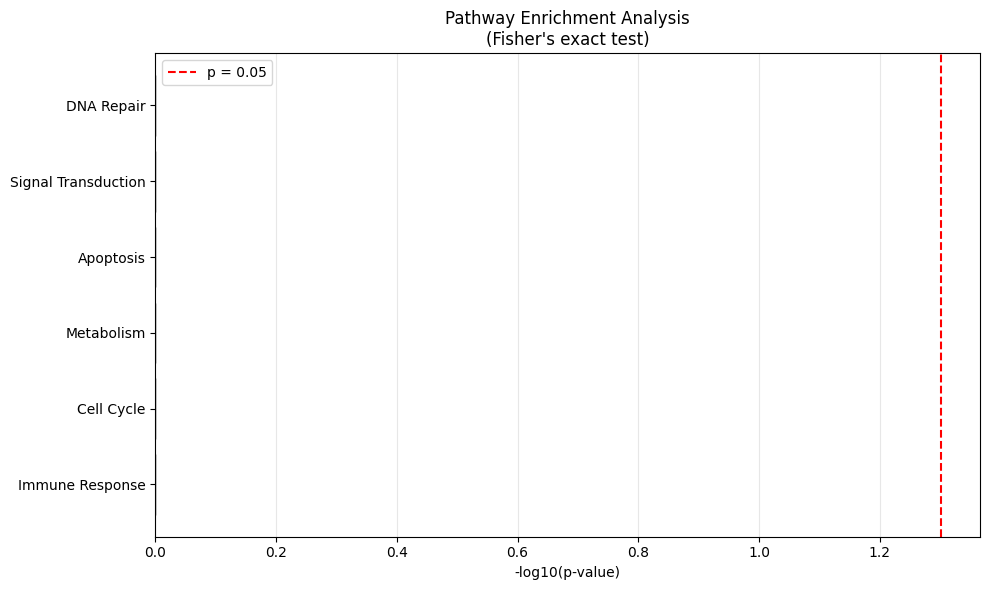

In [11]:
sorted_pathways = sorted(pathway_pvals.items(), key=lambda x: x[1])
names_pw = [p[0] for p in sorted_pathways]
pvals_pw = [p[1] for p in sorted_pathways]
neg_log_pvals = [-np.log10(p + 1e-10) for p in pvals_pw]

colors_pw = ['#e74c3c' if p < 0.05 else '#bdc3c7' for p in pvals_pw]

plt.figure(figsize=(10, 6))
plt.barh(names_pw, neg_log_pvals, color=colors_pw, edgecolor='black')
plt.axvline(-np.log10(0.05), color='red', linestyle='--', label='p = 0.05')
plt.xlabel('-log10(p-value)')
plt.title("Pathway Enrichment Analysis\n(Fisher's exact test)")
plt.legend()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Summary

| Concept | What you built | Why it matters |
|---------|---------------|----------------|
| Count matrix | NB-distributed gene x sample | RNA-seq raw data format |
| Normalization | CPM, DESeq2, UQ methods | Make samples comparable |
| DE testing | Per-gene hypothesis testing | Find responsive genes |
| Multiple testing | Benjamini-Hochberg FDR | Control false discovery rate |
| Volcano plot | Effect size x significance | Visual DE summary |
| Heatmap | Clustered expression patterns | Co-expression programs |
| Pathway enrichment | Fisher's exact test on gene sets | Biological interpretation |

**Connections to conceptual framework:**
- [[Signal Processing in Biological Systems]]: Count data as noisy biological signal
- [[Perturbation-Response-Adaptation]]: DE genes are the molecular response to perturbation
- [[Hierarchical Composition]]: Genes form coordinated programs, not isolated actors
- [[Multi-Omics Integration]]: RNA-seq is one layer; proteomics, metabolomics add context
- [[Context Conditionality]]: Same gene may be DE in one tissue but not another
- [[Adaptive Response]]: Differential expression captures the cell's adaptive program

**Next**: [[06_Clinical_Biomedical_Informatics]] -- survival analysis, EHR data, clinical endpoints